---
# 1. 필요 라이브러리 설치 및 불러오기
----

In [3]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [4]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

----
# 2. pretrained model 로딩하기
----

In [4]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [5]:
data_dir = '/content/drive/MyDrive/aiffel/EXP 13/data'
model_dir = '/content/drive/MyDrive/aiffel/EXP 13/data'

# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [6]:
# 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


json은 딕셔너리 혹은 리스트의 집합으로 이루어져 있다
<img src='https://t1.daumcdn.net/cfile/tistory/99D27F3D5D6A22B139'>

- Python 객체를 JSON 데이터로 쓰기, 직렬화, 인코딩: json.dumps()
     - separators : 구분문자를 지정
     - indent : 인덱스를 지정 
     - sort_keys : 키로 정렬
     - ensure_ascii : Unicode이스케이프 지정

In [7]:
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

----
# 3. 데이터셋 전처리
-----

-----
# 3-1 띄어쓰기 단위 정보관리
----

- ord(문자) : 특정한 한 문자를 아스키 코드 값으로 변환해 주는 함수
- chr(숫자) 함수 : 아스키 코드 값을 문자로 변환해 주는 함수 (10진수, 16진수 사용 가능)

In [8]:
# 공백
print(chr(0x202F))

In [9]:
def _is_whitespace(c):
  if c == ' ' or c == '\t' or c == '\r' or c == '\n' or ord(c) == 0x202F:
    return True
  return False

# 공백,\t,\r,\n,0x202F(공백)일 경우 True 반환 아니면 False

In [10]:
# whitespace가 2개인 경우를 처리해야 함

string1 = '1839년 파우스트를 읽었다.' # 띄어쓰기가 1개
string2 = '1839년  파우스트를 읽었다.' # 띄어쓰기가 2개
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [11]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

# 단어를 사이에 공백이 있으면 숫자가 1씩 증가

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


In [12]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


- 공백 함수화

In [13]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [14]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
  print(f'\'{c}\':{i}')
word_tokens, char_to_word

'1':0
'8':0
'3':0
'9':0
'년':0
' ':0
'파':1
'우':1
'스':1
'트':1
'를':1
' ':1
'읽':2
'었':2
'다':2
'.':2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [15]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

----
# 3-2 Tokenize by Vocab
----

- enumerate : 인덱스와 원소를 동시에 접근하면서 루프를 돌리는 방법
- 단어는 의미를 가진 더 작은 서브워드들의 조합으로 이루어진다.  
  빈도수에 따라 문자를 병합하여 subword를 구성한다. 
  예를 들면 "conference" -> 'con', 'f', 'er', 'ence' 로 분절 할 수 있다.
  한국어, 일본어, 영어 등 언어 형식에 구애받지 않고, 별도의 문법 입력 없이 조사 구분이 가능하다.
- spm.SentencePieceProcessor() = model 파일을 로드하여 단어 시퀀스를 정수 시퀀스로 바꾸는 인코딩 작업

- 하나씩 코드 뜯어보기

In [16]:
word_to_token = []
context_tokens = []
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

a = '1839년'
word_to_token.append(len(context_tokens))
word_to_token

[0]

In [17]:
tokens = vocab.encode_as_pieces(a)
tokens


['▁1839', '년']

In [18]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePiece를 사용해 Subword로 쪼갭니다.
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

# 0,2,5는 context_tokens에 담긴 0,2,5 토큰이 '_'를 포함 즉, 어절 단위의 첫 번째 토큰이라는 정보를 담아둠

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

- 코드 함수화

In [19]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

----
# 3-3 Improve Span
----

- assert는 뒤의 조건이 True가 아니면 AssertError를 발생

In [20]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [21]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print('word_tokens :' ,  word_tokens[:20])
print('char_to_word :',char_to_word[:20])
print('context :',context[:20])

word_tokens : ['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']
char_to_word : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]
context : 1839년 바그너는 괴테의 파우스트을


In [22]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [23]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [24]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [25]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [26]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


- ontext에서 answer의 위치를 토큰화된 상태에서 찾는 함수

In [27]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [28]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

----
# 3-4 데이터셋 분리
----

In [29]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f: # 파일 열기
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

- 전처리한 데이터셋을 새로 저장

In [30]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [31]:
def print_file(filename, count=10): # (파일 이름, 출력 라인 수)
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

----
# 3-5 Question
---

In [32]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
168 ['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
80 ['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
6 ['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
143 ['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
0 ['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
216 ['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
164 ['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
7 ['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


In [33]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

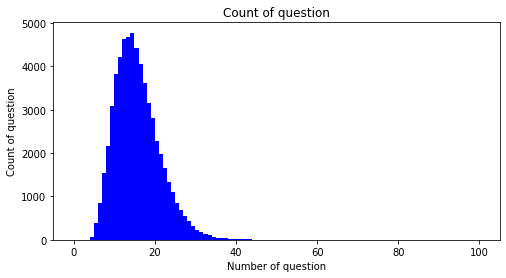

In [34]:
plt.figure(figsize=(8, 4))
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력

plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨

# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [35]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


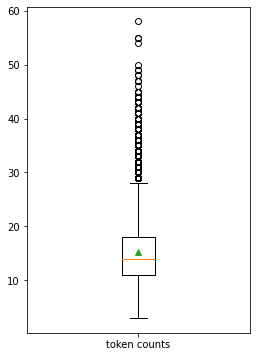

In [36]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
plt.show()

----
# 3-6 Context
----

In [37]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

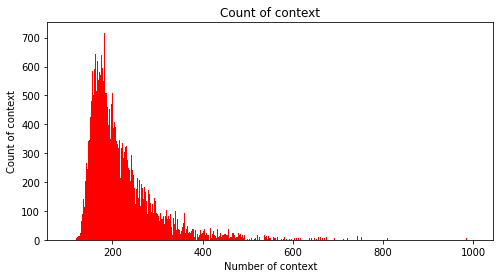

In [38]:
plt.figure(figsize=(8, 4))
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력

plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨

# 그래프 제목
plt.title('Count of context')
# 그래프 x 축 라벨
plt.xlabel('Number of context')
# 그래프 y 축 라벨
plt.ylabel('Count of context')
plt.show()

In [39]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


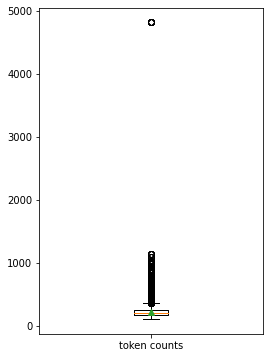

In [40]:
plt.figure(figsize=(4, 6))

plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
plt.show()

----
# 3-7 Answer
----

In [41]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

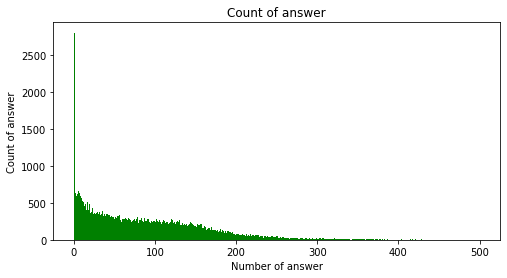

In [42]:
plt.figure(figsize=(8, 4))
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨

# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [43]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


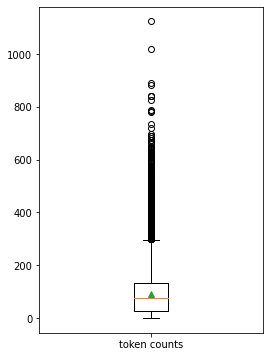

In [44]:
plt.figure(figsize=(4, 6))

plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현

plt.show()

---
# 3-8 Word Cloud
----

In [45]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # 그중 맨 앞 10개만 확인해 봅니다.

  0%|          | 0/1420 [00:00<?, ?it/s]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?']

In [46]:
# documents를 전부 이어 하나의 문장으로 만들면 이렇게 보입니다. 
" ".join(documents[:10])

'파우스트_서곡 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은? 바그너가 파우스트를 처음으로 읽은 년도는? 바그너가 처음 교향곡 작곡을 한 장소는? 바그너의 1악장의 초연은 어디서 연주되었는가?'

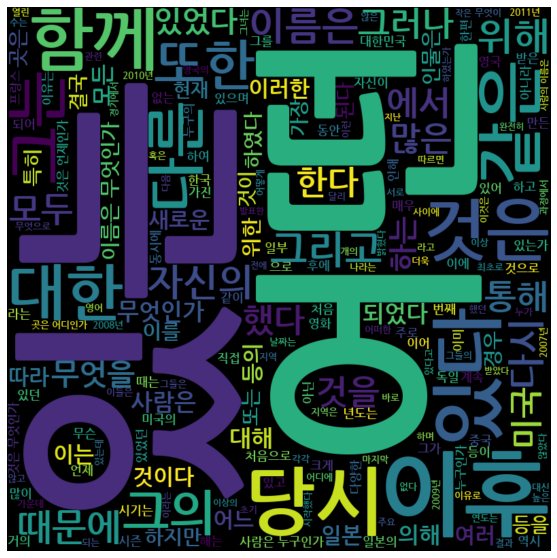

In [47]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(width=800, height=800, font_path='/content/drive/MyDrive/aiffel/EXP 12/NanumGothicBold.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

있는, 어떤, 있다, 함께, 이후 등등이 많이 보인다.

----
# 4. 데이터 로드
----

In [48]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

- __init__ : 클래스를 생성할 때 실행되는 생성자
- __getitem__ :  클래스의 인덱스에 접근할 때 자동으로 호출되는 메서드
- __setitem__ : 두번째 인자가 index 혹은 key가 되고, 세번째 인자가 해당 index, key의 값이 됨

In [49]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

In [50]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [51]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [52]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [53]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [54]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

----
# 5. BERT 모델 구조 형성
-----

----
# 5-1 패딩 마스크
----

- 쿼리 행렬과 키 행렬을 곱해준 attention score 행렬에서 pad 토큰에는 실질적인 의미가 없기 때문에,  
- 키에 패드 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않기 위해 "굉장히 작은 음수값"을 넣어주는데, 이것을 패딩 마스킹이라 한다.

- 아주 작은 음수값을 넣어주고, 소프트맥스 함수를 지나게 되면 마스킹된 이 위치의 값들은 0에 가까운 값이 되어 단어간 유사도를 구할 때 패드토큰이 반영되지 않게 된다.  
- 즉, 키에 패드 토큰이 있는 경우에는 열 전체에 아주 작은 음수를 넣어줌으로써 어텐션에서 제외하는 것을 패딩 마스킹이라고 한다.

In [55]:
# 유틸리티 함수
def get_pad_mask(tokens, i_pad=0):   # tokens (bs, n_seq) , id of pad
  mask = tf.cast(tf.math.equal(tokens,i_pad), tf.float32)
  mask = tf.expand_dims(mask, axis = 1) # 차원 확장
  return mask # pad mask( pad: 1, other: 0)

----
# 5-2 룩 어헤드 마스크
----

- 트랜스포머에서 사용한 룩 어헤드 마스킹으로, 문장 행렬로 들어가서 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측하기 때문에,  
다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹이다.  
- 이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 key 단어들에 대해 마스킹한다.

In [56]:
def get_ahead_mask(tokens, i_pad=0): 
  n_seq = tf.shape(tokens)[1]
  ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq,n_seq)),-1 ,0) # 하삼각행렬
  ahead_mask = tf.expand_dims(ahead_mask, axis = 0) # 차원 수를 맞추기 위함
  pad_mask = get_pad_mask(tokens,i_pad)
  mask = tf.maximum(ahead_mask, pad_mask) # 두 가지 배열 값 중 큰 값으로 배열 합치기 
  return mask

- tf.maximum 함수 확인해보기

In [6]:
# x = tf.constant([-5., 0., 0., 0.])
# y = tf.constant([-3.])
# tf.maximum(x,y)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-3.,  0.,  0.,  0.], dtype=float32)>

----
# 5-3 활성화 함수
----

In [58]:
@tf.function(experimental_relax_shapes=True) # 을 붙이면 tf2.x스타일이 아닌 tf1.x 스타일로 해당 함수내의 로직이 동작하며, 상황에 따라 속도가 약간 빨라질 수 있다.
def gelu(x): # GELU(Gaussian Error Linear Unit) 활성화함수
  return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

<img src='https://velog.velcdn.com/images%2Ftajan_boy%2Fpost%2Fec576626-720d-4313-a225-fbcc752964e8%2Fgelu.jpg'>

- GELU는 NLP 분야에서의 BERT, ROBERTa, ALBERT 등 최신 딥러닝 모델에서 굉장히 많이 사용되고 있는 활성화 함수

<img src='https://velog.velcdn.com/images%2Ftajan_boy%2Fpost%2F45e1f4b1-c342-43f4-ac51-afb7c333d974%2Fgelu%20비교.jpg'>

- 여러 결과들을 보면 GELU가 RELU, ELU 등의 타 활성화 함수들보다 빠르게 수렴, 낮은 오차를 보여준다.

https://velog.io/@tajan_boy/Computer-Vision-GELU

---
# 5-4 가중치와 편향 초기화 함수
----

In [9]:
def kernel_initializer(stddev=0.02): # 생성할 랜덤 변수의 표준편차
  return tf.keras.initializers.TruncatedNormal(stddev=stddev) # 잘린 정규분포를 생성하는 이니셜라이져

def bias_initializer():
  return tf.zeros_initializer # 0으로 초기화 된 텐서를 생성하는 이니셜 라이저.

class Config(dict): # json을 config 형태로 사용하기 위한 Class
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod # 정적매소드로 인스턴스를 만들지 않아도 class의 매서드를 바로 실행 가능
                 # staticmethod / classmethod 같은 내용이지만 classmethod는 cls라는 인자가 더 추가 된다.
    def load(cls, file):  # file에서 Config를 생성
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

---
# 5-5 Embedding 함수
---

In [60]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 
class SharedEmbedding(tf.keras.layers.Layer):
  def __init__(self, config, name = 'weight_shared_embedding'):
    super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴
    self.n_vocab = config.n_vocab # 위 상속받은 값에 해당 2줄 추가
    self.d_model = config.d_model
  
  def build(self, input_shape): # (tensor shape)
    with tf.name_scope('shared_embedding_weight'):
      self.shared_weights = self.add_weight('weights',
                                            shape=[self.n_vocab, self.d_model],
                                            initializer = kernel_initializer())
      
  def call(self, inputs, mode="embedding"): # (입력, 실행모드, 이름)
    # mode가 embedding일 경우 embedding lookup 실행
    if mode == "embedding":
      return self._embedding(inputs)
    # mode가 linear일 경우 linear 실행
    elif mode == "linear":
      return self._linear(inputs)
    # mode가 기타일 경우 오류 발생
    else:
      raise ValueError(f"mode {mode} is not valid.")

  def _embedding(self, inputs):
    embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
    # axis 축을 기준으로 원하는 index의 값을 뽑아온다 (x값에서 y값을 인덱스로 삼고 추출)
    return embed

  def _linear(self, inputs):  # (bs, n_seq, d_model)
    n_batch = tf.shape(inputs)[0]
    n_seq = tf.shape(inputs)[1]
    inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
    outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True) # 3차원 텐서 사이의 행렬곱
    outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)    
    return outputs


---
# 5-6 Positional Embedding
----

트랜스포머에선 포지셔널 인코딩이란 방법을 통해 단어의 위치 정보를 표현했다.  
sin 함수와 cos 함수를 사용하여 위치에 따라 다른 값을 가지는 행렬을 만들어 이를 단어 벡터들과 더하는 방식이었다.  
BERT는 이와 유사하지만 학습을 통해 위치 정보를 얻는 포지션 임베딩을 사용한다.  

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnWtIx%2Fbtrlhya7bl3%2FDQrxkBb8lumrun63pgTVz1%2Fimg.png'>

위 그림에서 보이듯 위치 정보를 위한 임베딩 층을 하나 더 사용한다.  
문장의 길이가 4라면 4개의 포지션 임베딩 벡터를 학습시키고, BERT의 입력마다 더해주는 방식이다.

  - 첫 번째 단어 임베딩 벡터 + 0번 포지션 임베딩 벡터
  - 두 번째 단어 임베딩 벡터 + 1번 포지션 임베딩 벡터
  - 세 번째 단어 임베딩 벡터 + 2번 포지션 임베딩 벡터
  - 네 번째 단어 임베딩 벡터 + 3번 포지션 임베딩 벡터

https://moondol-ai.tistory.com/463

In [61]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())
                        # 양의 정수 (인덱스)를 고정 크기의 밀도가 높은 벡터로 바꾼다
    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed # positional embedding lookup 결과

- tf.cumsum /ones_like 함수 확인해보기

In [7]:
# # axis 따라 텐서 x 의 누적 합을 계산
# a = tf.constant([2, 4, 6, 8])
# print('tf.cumsum의 결과값')
# print(tf.cumsum(a))
# print('='*50)

# # exclusive kwarg를 True 로 설정하면 배타적 cumsum이 대신 수행됩니다.
# print('tf.cumsum 및 exclusive = True의 결과값')
# print(tf.cumsum(a,exclusive = True))
# print('='*50)

# # 입력과 모양이 같은 모든 텐서를 만들며, 값은 one으로 통일
# print('tf.ones_like의 결과값')
# print(tf.ones_like(a))

tf.cumsum의 결과값
tf.Tensor([ 2  6 12 20], shape=(4,), dtype=int32)
tf.cumsum 및 exclusive = True의 결과값
tf.Tensor([ 0  2  6 12], shape=(4,), dtype=int32)
tf.ones_like의 결과값
tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)


- embedding 과정 및 결과값 확인해보기

In [10]:
# # 예시 코드
# bb = [[1,2],[3,4],[5,0]]
# position = tf.cast(tf.math.cumsum(tf.ones_like(bb), axis=1, exclusive=True), tf.int32)
# embedding = tf.keras.layers.Embedding(512, 256, embeddings_initializer=kernel_initializer())
# bb = embedding(position)
# print('embedding된 행렬: ',bb)
# print('행렬의 shape:',bb.shape)
# print('행렬의 type:',type(bb))

embedding된 행렬:  tf.Tensor(
[[[ 0.0194146   0.01562443 -0.00443909 ...  0.01400511  0.03627416
    0.00284145]
  [ 0.00732453 -0.00956937 -0.01222667 ...  0.0224336   0.0132496
   -0.00720581]]

 [[ 0.0194146   0.01562443 -0.00443909 ...  0.01400511  0.03627416
    0.00284145]
  [ 0.00732453 -0.00956937 -0.01222667 ...  0.0224336   0.0132496
   -0.00720581]]

 [[ 0.0194146   0.01562443 -0.00443909 ...  0.01400511  0.03627416
    0.00284145]
  [ 0.00732453 -0.00956937 -0.01222667 ...  0.0224336   0.0132496
   -0.00720581]]], shape=(3, 2, 256), dtype=float32)
행렬의 shape: (3, 2, 256)
행렬의 type: <class 'tensorflow.python.framework.ops.EagerTensor'>


----
# 5-7 Scale Dot Product Attention
---

<img src='https://cdn-images-1.medium.com/max/1600/1*m-NRoagK_I5fFvBjjS7TZg.png'>

Scaled Dot-Product Attention은 입력값으로 Q, K, V 세 개를 받는다.  
이는 입력값에 대한 플레이스 홀더로 맨 처음에는 임베딩의 fully-connected 결과, 두 번째 부터는 RNN과 유사하게 이전 인코더 블럭의 결과를 다음 인코더 블럭의 입력으로 사용한다.  
원래 Transformer에서 Q = 디코더의 히든 스테이트, K = 인코더의 히든 스테이트, V = K에 어텐션을 부여 받은 Normalized Weights가 되며, 초기값은 V와 K가 동일하다.  
그러나 BERT는 디코더를 사용하지 않으며 Q, K, V의 초기값이 모두 동일하다.  
저마다 각각 다른 초기화로 인해 실제로는 서로 다른 값에서 출발하지만 입력값의 구성은 동일하다. BERT는 이처럼 동일한 토큰이 문장내의 다른 토큰에 대한 Self-Attention 효과를 갖는다.

<img src='https://cdn-images-1.medium.com/max/1600/1*nCznYOY-QtWIm8Y4jyk2Kw.png'>

https://docs.likejazz.com/bert/#scaled-dot-product-attention

In [64]:
class ScaleDotProductAttention(tf.keras.layers.Layer):

    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴

    def call(self, Q, K, V, attn_mask): # attn_mask: 실행모드

        attn_score = tf.matmul(Q, K, transpose_b=True) # 3차원 텐서 사이의 행렬곱 
        # 단순히 2차원 행렬을 여러 층으로 쌓은 3차원 텐서에서 각 층 사이의 2차원 행렬 간의 곱을 리턴
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32)) #tf.math.sqrt = 입력 텐서의 요소 별 제곱근을 계산
        attn_scale = tf.math.divide(attn_score, scale) # x를 y로 나누기
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1) # softmax의 활성화를 구함
        attn_out = tf.matmul(attn_prob, V) # 3차원 텐서 행렬곱
        return attn_out # attention 실행 결과

-----
# 5-8 Multi Head Attention
-----

Scaled Dot Product Attention을 병렬적으로 수행하고 결과값을 Concat하는 방식이다.  
하나의 Attention만 사용했을 때 한쪽으로 쏠릴 수 있는 문제를 분산할 수 있다.  
병렬처리 되기 때문에 각 Attention 단위 Q,K,V 관련된 Weight Vector 또한 별도로 정의되며,  
<img src='https://i0.wp.com/hugrypiggykim.com/wp-content/uploads/2018/12/bert_010.jpg?w=899'>  

같은 X값을 기준으로 여러개의 Z를 생성한다.  
여러개의 Attention결과를 종합하면 가중치가 잘 분배된 Attention vector를 얻을 수 있다

http://hugrypiggykim.com/2018/12/09/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/


- 병렬 어텐션의 효과
  - 예문) 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤했기 때문이다.
  - 단어 '그것'이 쿼리라면, 첫번째 어텐션 헤드는 '그것'을 '동물'과 연관도를 높게보고  
  - 두번째 어텐션 헤드는 '그것'과 '피곤했기 때문이다'를 의 연관도를 더 높게 볼 수 있다.

- 멀티 헤드 어텐션 구현 과정
  -  Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
  - 지정된 헤드 수(num_heads)만큼 나눈다(split)
  - 병렬 스케일드 닷 프로덕트 어텐션를 지난다.
  - 나눠졌던 헤드들을 연결(concatenatetion)한다.
  - WO에 해당하는 밀집층을 지나게 한다.

https://velog.io/@cha-suyeon/멀티-헤드-어텐션Multi-head-Attention-구현하기

In [65]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴

        self.d_model = config.d_model 
        self.n_head = config.n_head
        self.d_head = config.d_head # 위 상속받은 값에 해당 3줄 추가

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask): # attn_mask: 실행 모드

        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # 행렬의 전치
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out # attn_out: attention 실행 결과

----
# 5-9 Position Wise Feed Forward
----

- 멀티 헤드 어텐션에서 나온 다양한 정보들을 합쳐주는 역할

- linear transforamtion을 적용한 다음에 GELU(FFN(x)=max(0,xW1+b1)W2+b2)를 거쳐  
  다시한번 linear transforamtion을 적용한다.
- 각 position마다 같은 W,b를 사용하지만 layer가 달라지면 다른 값을 사용한다.

In [66]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val # feed forward 실행 결과

---
# 5-10 Encoder Layer
---

- batch nomalization과 layer nomalization 차이점
  <img src='https://yonghyuc.files.wordpress.com/2020/03/bn_vs_ln.png'>  
  
  - BN은 batch에 있는 “모든” sample들에 대해서 “각 feature의 평균과 분산”을 구하여 정규화 하는 것이다.    
    따라서 BN은 batch 전반에 걸쳐 처리되므로 batch size와 관련이 깊다 
  - LN은 “각 sample에 대해서” “feature들에 대해서 평균과 분산”을 구해서 정규화 하는 것이다.  
따라서 각 input에 대해서만 처리되므로 batch size와는 전혀 상관이 없다.

In [67]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name) # tf.keras.layers.Layer의 __init__을 상속받아옴

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        # 계층 정규화 = 각 예에서 평균 활성화를 0에 가깝고 활성화 표준 편차를 1에 가깝게 유지하는 변환을 적용
        # 텐서가 주어지면 inputs 모멘트가 계산되고 축에 지정된 axis 에서 정규화가 수행 됨
        # why? 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원활하게 수행되기 때문

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask): #(enc_embed 또는 이전 EncoderLayer의 출력, enc_tokens의 pad mask)
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out # EncoderLayer 실행 결과

----
# 5-11 BERT
----

### BERT의 특징은 MaskedLM과 NSP(Next Sentence Predition)이다.

- MaskedLM은 자기 자신을 참조하는 문제를 해결하기 위해 마스크를 씌웠다.  
  하지만 문장에 MASK를 씌우는 거는 Pre-trained 학습에서만 하지 실제 fine-tuning 할 때는 씌우지 않기 때문에 간극이 발생할 것이라 생각하고,  
  Mask token의 80%는 mask로 / 10%는 random word로 / 10%는 unchanged word로 넣어 일부로 Noise를 넣음으로서 Deep 한 모델에서 발생할 수 있는 Over-fitting문제를 회피하도록 의도하였다고 한다.
- 예시)   
  Mask token의 80% : 내 개는 크다 -> 내 개는 [MASK]  
  Mask token의 10% : 내 개는 크다 -> 내 개는 사과  
  Mask token의 10% : 내 개는 크다 -> 내 개는 크다

- NSP(Next Sentence Predition)

  <img src='https://d3s0tskafalll9.cloudfront.net/media/images/E-18-01.max-800x600.png'>

- Token Embedding = Subwordtokenizer와 같은 것을 사용해 벡터 값을 가져온다.
  - Subwordtokenizer는 단어 보다 더 작은 단위로 쪼개는 방법으로,  
  기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만, 자주 등장하지 않는 단어는 더 작은 단위인 서브워드로 분리되어 서브워드들이 단어 집합에 추가한다.  
  그로인해, OOV문제를 해소할 수 있다.  
  예를 들면, BERT의 단어 집합에 em, ##bed, ##ding, #s라는 서브워드들이 존재한다면 embeddings는 em, ##bed, ##ding, #s로 분리된다.  
  (##은 서브워드들이 단어 중간부터 등장함을 알리는 기호이다.) <br><br>
- Segment Embedding = 단어가 첫번째 문장에 속하는지 두번째 문장에 속하는지 알려준다.  
[ 0 0 0 0 0 1 1 1 1 ] 과 같이 표현하며 해당 Vector를 Token Embedding 차원수와 같게 맞추어 임베딩 해준다. <br><br>

- Positional Embedding = 각 단어가 첫번째인지 두번째인지를 의미하는 Embedding 값이다.  
 마찬가지로 Token Embedding의 차원수와 맟춰 임베딩 한 후 더해준다.


https://moondol-ai.tistory.com/463  
https://vhrehfdl.tistory.com/15

In [68]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments): # (encoder tokens, token segment)

        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm # CLS 결과 logits / LM 결과 logits
    
    def get_embedding(self, tokens, segments): # (입력 tokens, 입력 segment)
    
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed # embedding 결과

---
# 6. BERT를 통한 모델 학습
---

In [69]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

- d_model = 인코더/디코더 입력에서 예상되는 기능의 수
- n_head = 멀티헤드어텐션 모델의 머리 수
- d_head = 
- d_ff = 피드포워드 모델의 차원
- n_layer = layer의 길이
- n_seq = sequence의 길이
- n_vocab = vocab의 길이
- i_pad = padding은 값은 0
- dropout = 드롭아웃값
- layernorm_epsilon = 레이어 정규화 구성 요소의 eps 값(기본값=1e-5)


In [70]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 512,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 8,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007}

- mini BERT

In [71]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [72]:
model = BERT4KorQuAD(config)

In [74]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss') # 주어진 값의 가중평균을 구함
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape: # tf.GradientTape = 입력 값에 대한 연산의 미분값을 자동으로 계산
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [75]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [76]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# 학습과정 시각화
start_loss_list = []
end_loss_list = []
start_acc_list = []
end_acc_list = []

best_acc = .0
patience = 0
for epoch in range(4):
    # train set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    start_loss_list.append(start_loss)
    end_loss_list.append(end_loss)
    start_acc_list.append(start_acc)
    end_acc_list.append(end_acc)
    
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9505, acc: 0.0290, 0.0005
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0042, 0.0011


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.4141, 5.4012, acc: 0.0053, 0.0056
early stopping


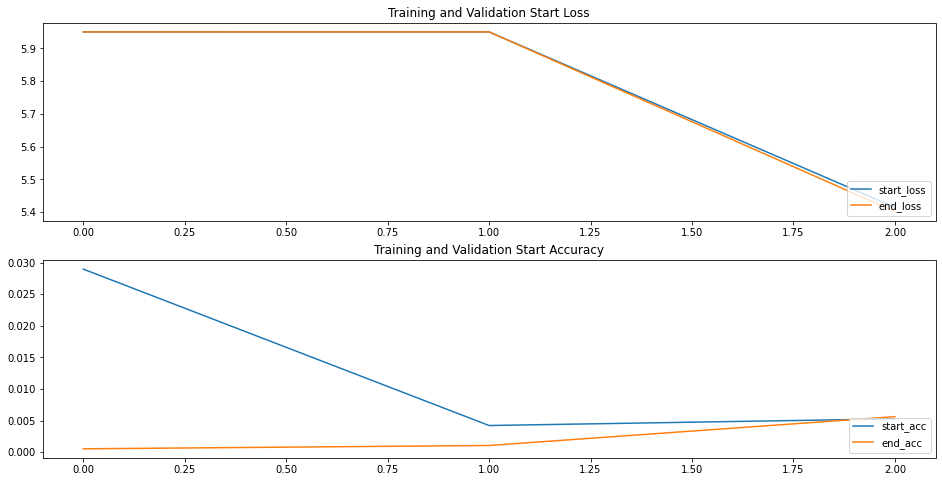

In [77]:
epochs_range = range(len(start_loss_list))

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, start_loss_list, label='start_loss')
plt.plot(epochs_range, end_loss_list, label='end_loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Start Loss')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, start_acc_list, label='start_acc')
plt.plot(epochs_range, end_acc_list, label='end_acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Start Accuracy')


plt.show()

In [79]:
def do_predict(model, question, context): #(모델, 입력 문자열, 입력 문자열)

    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [80]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 40 < i:
            break

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  임수경
예측 :  6월 30일 평양축전에 대표로 파견 된 인물은?[SEP] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하

- mini BERT의 경우 정답값과 예측값을 뽑아내는 것에 있어서 큰 차이를 보임을 확인 할 수 있다.
- 한 단어면 끝날 정답을 구구절절하게 길게 늘어나 있는 것을 볼 수 있으며,  
- 첫 번째 예측값의 경우 문장 중간에 [sep]의 값이 나오는 등 결과값이 좋지 못함을 확인 할 수 있다.

----
# 7. Pretrain Model 로딩하기
----

In [81]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_110 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [82]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

# 학습과정 시각화
pre_start_loss_list = []
pre_end_loss_list = []
pre_start_acc_list = []
pre_end_acc_list = []

for epoch in range(7):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    
    # 학습과정 시각화
    pre_start_loss_list.append(start_loss)
    pre_end_loss_list.append(end_loss)
    pre_start_acc_list.append(start_acc)
    pre_end_acc_list.append(end_acc)

    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.8227, 2.0246, acc: 0.5307, 0.5044
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6922, 1.9603, acc: 0.5646, 0.5312
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.7233, 1.9453, acc: 0.5758, 0.5339
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.0403, 2.2448, acc: 0.5762, 0.5400
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 1.9740, 2.2711, acc: 0.5715, 0.5279


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 2.0234, 2.6783, acc: 0.5467, 0.4956


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 2.4113, 2.7661, acc: 0.5455, 0.4977
early stopping


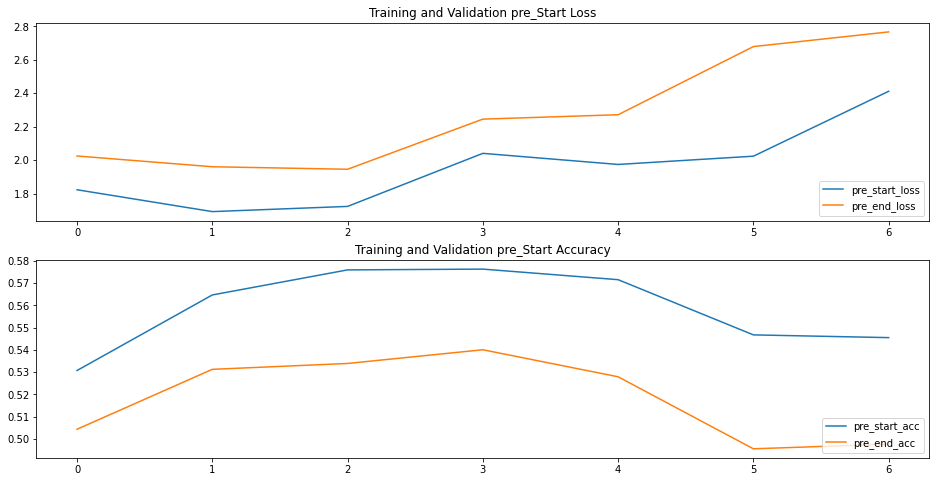

In [88]:
pre_epochs_range = range(len(pre_start_loss_list))

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(pre_epochs_range, pre_start_loss_list, label='pre_start_loss')
plt.plot(pre_epochs_range, pre_end_loss_list, label='pre_end_loss')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Loss')

plt.subplot(2, 1, 2)
plt.plot(pre_epochs_range, pre_start_acc_list, label='pre_start_acc')
plt.plot(pre_epochs_range, pre_end_acc_list, label='pre_end_acc')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Accuracy')


plt.show()

3epoch을 지나는 경우 loss값과 accuracy값이 부정적인 방향으로 움직임을 확인 할 수 있다.

In [87]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 35 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

- 대부분의 예측값이 정답값과 거의 동일하거나 비슷한 답을 예측하고 있다.

----
# 8. Otimizer 바꿔보기
---

----
# 8-1 AdamW + learning_rate = 2e-5
----

- BERT를 Fine-turning할때, pretrained된 데이터가 크면 클수록 문제를 야기할 수 있다고한다.  
  (물론 지금과 같은 pretrain 데이터에서는 BERT-large or BERT-base 보다는 문제점이 약하게 들어날 것이라 생각된다.)
  - 기존에 존재하던 불안정성에 대한 흔한 가설에는 2가지가 존재한다고 한다.
  - Catastrophic forgetting = 인공신경망이 새로운 정보를 학습할 때, 이전의 정보를 잊는 문제
  - Small training dataset = 작은 데이터셋으로 학습

- 해당 논문의 저자에 의하면 위 2가지 가설은 틀렸고, 저자가 찾은 원인에는 2가지가 있다고 한다.
  - 최적화의 어려움(Optimization Difficulties)으로 인한 기울기 소실 문제
  - 학습 후기의 모델의 서로 다른 일반화 문제

- 기존에 존재하던 불안정성에 대한 가설을 검증하는 방법은 해당 글에 설명이 되어 있다.  
  https://chloelab.tistory.com/33  

- 논문에서 권고하는 학습 방식은 아래와 같다.
  - 1. 작은 learning rate로 Bias correction을 수행하여 학습 초기의 Vanishing gradient 현상을 방지하자.  
    (BERT를 Bias-Correction이 있는 ADAM Optimizer으로 초기 학습율을 2e-5로 설정)
  - 2. 훈련 iteration을 늘려 training loss가 거의 0이 될 때 까지 훈련시키자.



- 해당 값을 토대로 현재 learning_rate=5e-4 보다 더 작은 2e-5 값으로 수정하고  
Adam을 그대로 사용하려 하였으나, AdamW라는 것을 알게되었다.

- 알게된 배경에는  Kaggle 대회 “Understanding Clouds from Satellite Images” 에서 다른 사람들은 Radam을 사용하였으나 1등을 하신 한국분이 AdamW를 사용하셨다고 하여 알게 되었다. 

- Adam과 비교하여 AdamW는 모든 lr schedule에 대해 좋은 성능을 얻었으며,  
학습 초기에는 Adam과 AdamW과 비슷한 loss를 보이지만 학습이 진행될 수록 AdamW의 훈련 손실과 test 에러가 더 낮아진다고 한다.

- optimizer를 수정해 다시 모델을 학습시켜 보고 결과값을 비교해보겠다.


- https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html
- https://aimaster.tistory.com/76?category=434406

In [151]:
model2 = BERT4KorQuAD(config)
enc_tokens = np.random.randint(0, len(vocab), (4, 10))
segments = np.random.randint(0, 2, (4, 10))
model2(enc_tokens, segments)
model2.load_weights(os.path.join(model_dir, 'korquad_bert_none_pretrain_2.hdf5'),by_name=True)

In [152]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model2(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model2.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model2.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_554 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [153]:
import tensorflow_addons as tfa

In [154]:
optimizer2 = tfa.optimizers.AdamW(weight_decay=0.001,learning_rate=2e-5)

In [155]:
loss_fn2 = tf.keras.losses.sparse_categorical_crossentropy
acc_fn2 = tf.keras.metrics.sparse_categorical_accuracy

best_acc2 = .0
patience2 = 0

# 학습과정 시각화
pre_start_loss_list2 = []
pre_end_loss_list2 = []
pre_start_acc_list2 = []
pre_end_acc_list2 = []

for epoch in range(7):
    train_epoch(model2, train_dataset, loss_fn2, acc_fn2, optimizer2)
    start_loss2, end_loss2, start_acc2, end_acc2 = eval_epoch(model2, dev_dataset, loss_fn2, acc_fn2)
    print(f'eval {epoch} >> loss: {start_loss2:0.4f}, {end_loss2:0.4f}, acc: {start_acc2:0.4f}, {end_acc2:0.4f}')
    acc2 = start_acc2 + end_acc2
    
    # 학습과정 시각화
    pre_start_loss_list2.append(start_loss2)
    pre_end_loss_list2.append(end_loss2)
    pre_start_acc_list2.append(start_acc2)
    pre_end_acc_list2.append(end_acc2)

    if best_acc2 < acc2:
        patience = 0
        best_acc2 = acc2
        model2.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain_2.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 4.2219, 4.7488, acc: 0.0665, 0.0521
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 4.8378, 5.2883, acc: 0.0741, 0.0446


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.6512, 5.7155, acc: 0.0311, 0.0286


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.8102, 5.8285, acc: 0.0158, 0.0172
early stopping


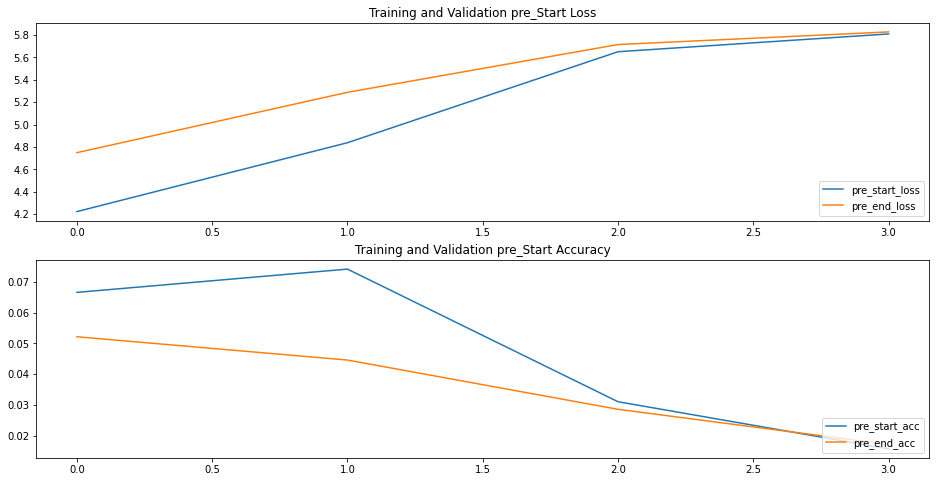

In [156]:
pre_epochs_range2 = range(len(pre_start_loss_list2))

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(pre_epochs_range2, pre_start_loss_list2, label='pre_start_loss')
plt.plot(pre_epochs_range2, pre_end_loss_list2, label='pre_end_loss')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Loss')

plt.subplot(2, 1, 2)
plt.plot(pre_epochs_range2, pre_start_acc_list2, label='pre_start_acc')
plt.plot(pre_epochs_range2, pre_end_acc_list2, label='pre_end_acc')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Accuracy')


plt.show()

- leraning_rate가 너무 작아 미세한 움직임을 보이며, early stopping을 걸어 놓아 accuracy값이 0.01 정도로 매우 낮은 정확도를 보이고 있다.

In [159]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model2, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

- 정확도가 너무 낮다보니 어떤한 값도 생성하지 못하는 것을 볼 수 있다.

----
# 8-2. Adam + learning_Rate = 2e-5
---

In [160]:
model3 = BERT4KorQuAD(config)
enc_tokens = np.random.randint(0, len(vocab), (4, 10))
segments = np.random.randint(0, 2, (4, 10))
model3(enc_tokens, segments)
model3.load_weights(os.path.join(model_dir, 'korquad_bert_none_pretrain_3.hdf5'),by_name=True)

In [161]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model3(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model3.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model3.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_591 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [162]:
loss_fn3 = tf.keras.losses.sparse_categorical_crossentropy
acc_fn3 = tf.keras.metrics.sparse_categorical_accuracy

optimizer3 = tf.keras.optimizers.Adam(learning_rate=2e-5)

best_acc3 = .0
patience3 = 0

# 학습과정 시각화
pre_start_loss_list3 = []
pre_end_loss_list3 = []
pre_start_acc_list3 = []
pre_end_acc_list3 = []

for epoch in range(7):
    train_epoch(model3, train_dataset, loss_fn3, acc_fn3, optimizer3)
    start_loss3, end_loss3, start_acc3, end_acc3 = eval_epoch(model3, dev_dataset, loss_fn3, acc_fn3)
    print(f'eval {epoch} >> loss: {start_loss3:0.4f}, {end_loss3:0.4f}, acc: {start_acc3:0.4f}, {end_acc3:0.4f}')
    acc3 = start_acc3 + end_acc3
    
    # 학습과정 시각화
    pre_start_loss_list3.append(start_loss3)
    pre_end_loss_list3.append(end_loss3)
    pre_start_acc_list3.append(start_acc3)
    pre_end_acc_list3.append(end_acc3)

    if best_acc3 < acc3:
        patience = 0
        best_acc3 = acc3
        model3.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 2.2333, 2.4400, acc: 0.4342, 0.3899
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.9107, 2.1277, acc: 0.5105, 0.4712
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 2.2584, 2.4091, acc: 0.5118, 0.4649


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 3.3406, 3.4112, acc: 0.4925, 0.4603


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 3.5056, 3.7502, acc: 0.5065, 0.4619
early stopping


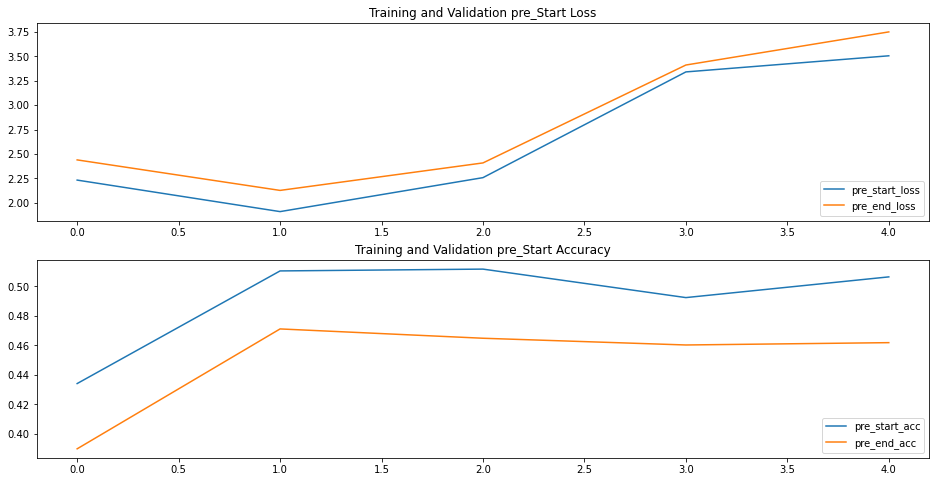

In [163]:
pre_epochs_range3 = range(len(pre_start_loss_list3))

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(pre_epochs_range3, pre_start_loss_list3, label='pre_start_loss')
plt.plot(pre_epochs_range3, pre_end_loss_list3, label='pre_end_loss')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Loss')

plt.subplot(2, 1, 2)
plt.plot(pre_epochs_range3, pre_start_acc_list3, label='pre_start_acc')
plt.plot(pre_epochs_range3, pre_end_acc_list3, label='pre_end_acc')
plt.legend(loc='lower right')
plt.title('Training and Validation pre_Start Accuracy')

plt.show()

In [164]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model3, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 40 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

---
# 9. 전체 결과값 한눈에 시각화 하기
---

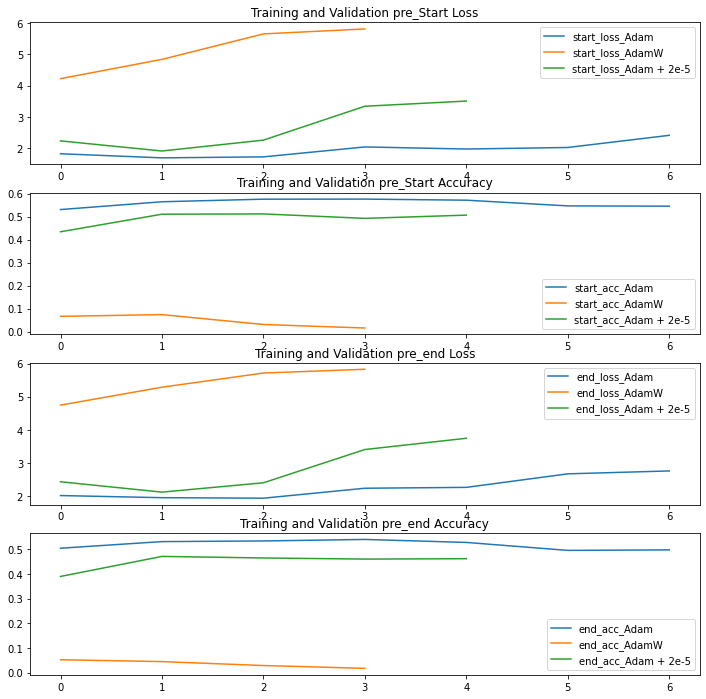

In [165]:
pre_epochs_range = range(len(pre_start_loss_list))
pre_epochs_range2 = range(len(pre_start_loss_list2))
pre_epochs_range3 = range(len(pre_start_loss_list3))

plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(pre_epochs_range, pre_start_loss_list, label='start_loss_Adam')
plt.plot(pre_epochs_range2, pre_start_loss_list2, label='start_loss_AdamW')
plt.plot(pre_epochs_range3, pre_start_loss_list3, label='start_loss_Adam + 2e-5')
plt.legend(loc='best')
plt.title('Training and Validation pre_Start Loss')

plt.subplot(4, 1, 2)
plt.plot(pre_epochs_range, pre_start_acc_list, label='start_acc_Adam')
plt.plot(pre_epochs_range2, pre_start_acc_list2, label='start_acc_AdamW')
plt.plot(pre_epochs_range3, pre_start_acc_list3, label='start_acc_Adam + 2e-5')
plt.legend(loc='best')
plt.title('Training and Validation pre_Start Accuracy')

plt.subplot(4, 1, 3)
plt.plot(pre_epochs_range, pre_end_loss_list, label='end_loss_Adam')
plt.plot(pre_epochs_range2, pre_end_loss_list2, label='end_loss_AdamW')
plt.plot(pre_epochs_range3, pre_end_loss_list3, label='end_loss_Adam + 2e-5')
plt.legend(loc='best')
plt.title('Training and Validation pre_end Loss')

plt.subplot(4, 1, 4)
plt.plot(pre_epochs_range, pre_end_acc_list, label='end_acc_Adam')
plt.plot(pre_epochs_range2, pre_end_acc_list2, label='end_acc_AdamW')
plt.plot(pre_epochs_range3, pre_end_acc_list3, label='end_acc_Adam + 2e-5')
plt.legend(loc='best')
plt.title('Training and Validation pre_end Accuracy')

plt.show()

----
# 회고
----

- 읽었던 논문에서도 훈련량을 늘리면 loss값이 작아진다고 하였으나, 시간상 여러번의 epoch을 줄 수 없어서 확인해보지 못 한 것이 아쉽다.<br><br>
- Transformer를 공부할 때, 대충 보고 넘어간 이후 다시 BERT를 접하게 되어서 BERT는 잘 이해하고 넘어가보고자 코드를 뜯어보고 확인해 보았지만,  
코드 자체가 헷갈리고 어려운 부분이 많았으며, 이해하고 넘아간줄 알았는데  
다른 사람들과 대화를 해보면서 이해가 부족한 부분이 많이 있었음을 확인 할 수 있었다. <br><br>
- 미약하지만 BERT에 대해서 알수 있는 좋은 기호였고, 코드를 하나씩 뜯어보는 것에 대한 장점을 다시한번 느낄 수 있었다.<br><br>
- BERT가 현재 NLP에서 가장 인기있고 많이 활용되는 만큼 다양하며 비슷한 유형의 BERT모델이 있음을 알게 되었다.<br><br>
- 특히 SKT에서 만든 한국어 BERT인 KOBERT를 활용해보고 기존의 모델과 비교해 보고 싶었지만,  
시간 관계상 + 코드의 어려움으로 인해 시도를 해보지 못하였다. 추후 기회가 된다면 해당 모델도 확인해 보고 싶다. <br><br>
- Adam과 AdamW를 같은 값으로 놓았으나 결과는 정반대 였다. 해당 이유에 대해서 고민해 보자면 둘의 가장 큰 차이는 weight decay(가중치 증가 제한)이다. 변수를 업데이트 함에 있어서 가중치의 증가를 제한함으로 인해 변화해야 하는 가중치만큼 가중치가 변화하지 못해 오류가 날 수 있다고 생각이 든다.<br><br>
- 논문을 토대로 Optimizer를 바꿔본 결과 learning_rate가 작을수록 미세하게 움직이게 되고, early stopping을 걸어두어서 global optimum을 찾지못하고 중지된 것을 볼 수 있었다. <br><br>
- 논문을 잘 이해하지 못하였기 때문일 수도 있고, 논문은 BERT, RoBERTa, ALBERT와 같은 대형 모델에서 fine-turning을 하는 과정에서 optimizer의 작은 값이 들어가는 것이 옳다고 하였으나, 여기서 사용된 모델은 그 정도의 사이즈가 아니기 때문에 오히려 문제를 야기한 것 같다.<br><br>
- 모델의 하이퍼파라미터 값을 바꾸는 과정에서 생각했던 값이 나오지 않고, 망한 모델이 나온 값을 보니 어이없으면서도 재밌는 경험을 하게 된 것 같다.<br><br>